# Notebook to merge and clean logfiles

When Basilisk simulations are run for longer times on a cluster, the log-information will be spread over multiple files. Sometimes these contain error messages, for example, from the cluster, which have to be removed. Because restart files are not written after each time loop/iteration, there is duplicated data in the logs which also has to be removed. The aim of this notebook is to

- read the log files for all simulations which were run on Moabmaster and the Lichtenberg cluster
- select only files which actually contain sensible logs and remove erroneous lines
- save the cleaned and merged logs for each simulation
- read the new logs and display the terminal velocity as a first sanity check

The log files are structured as follows:

- log files from Lichtenberg start with **err.** and files from Moabmaster start with **bubble_**
- there are 12 different setups with 3 refinement levels per setup (l12, l13, l14) in folders named **bubble_\[1-12\]_l\[12-14\]**

In [1]:
# create paths to folders
source_base = "/media/weiner/Volume/basilisk/basilisk"
target_base = "/media/weiner/Volume/basilisk/basilisk"
names_3D = ["bubble_" + str(case) + "_" + level for case in range(5, 13) for level in ["l12", "l13", "l14"]]
names_2D_bhaga = ["bhaga_{:02d}".format(case) + "_" + level for case in range(2, 5) for level in ["l14", "l15", "l16"]]
names_2D_water = ["water_{:02d}".format(case) + "_" + level for case in range(2, 5) for level in ["l14", "l15", "l16"]]
names = names_3D + names_2D_bhaga + names_2D_water
print(names)

['bubble_5_l12', 'bubble_5_l13', 'bubble_5_l14', 'bubble_6_l12', 'bubble_6_l13', 'bubble_6_l14', 'bubble_7_l12', 'bubble_7_l13', 'bubble_7_l14', 'bubble_8_l12', 'bubble_8_l13', 'bubble_8_l14', 'bubble_9_l12', 'bubble_9_l13', 'bubble_9_l14', 'bubble_10_l12', 'bubble_10_l13', 'bubble_10_l14', 'bubble_11_l12', 'bubble_11_l13', 'bubble_11_l14', 'bubble_12_l12', 'bubble_12_l13', 'bubble_12_l14', 'bhaga_02_l14', 'bhaga_02_l15', 'bhaga_02_l16', 'bhaga_03_l14', 'bhaga_03_l15', 'bhaga_03_l16', 'bhaga_04_l14', 'bhaga_04_l15', 'bhaga_04_l16', 'water_02_l14', 'water_02_l15', 'water_02_l16', 'water_03_l14', 'water_03_l15', 'water_03_l16', 'water_04_l14', 'water_04_l15', 'water_04_l16']


In [2]:
# helper functions
import glob
import os
import pandas as pd

def get_log_list(path):
    '''Search for Moab or Lichtenberg log files.
    
    Parameters
    ----------
    path - string : where to search
    
    Returns
    -------
    logs - array-like : list of log file names
    
    '''
    licht = glob.glob(path + "/err.*")
    moab = glob.glob(path + "/bubble*")
    return licht + moab


def read_and_clean_logs(path):
    '''Read single log files from disk, clean, and merge.
    
    Parameters
    ----------
    path - string : path where to search for files
    
    Returns
    -------
    full_log - DataFrame : merged log file as Pandas dataframe
    
    '''
    files = get_log_list(path)
    if not files:
        raise NameError("No log files found.")
        
    names = ['time', 'volume', 'x', 'y', 'z', 'u_x', 'u_y', 'u_z', 'omega_x', 'omega_y', 'omega_z', 'area']
    logs = []
    for file in files:
        raw_log = pd.read_csv(file, sep=' ', header=None, names=names)
        raw_log.dropna(inplace=True)
        clean_log = raw_log[pd.to_numeric(raw_log.time, errors='coerce').isnull() == False].reset_index(drop=True)
        logs.append(clean_log.apply(pd.to_numeric))
    full_log = pd.concat(logs)
    full_log = full_log.drop_duplicates("time").sort_values(by='time')
    return full_log.reset_index(drop=True)


def process_logs(source, target):
    '''Wrapper function to read and save log files.
    
    Parameters
    ----------
    source - string : where to search for log files
    target - string : file path + name to store log file as .csv
    
    '''
    if not os.path.isdir(source):
        print("Skipping case {}: directory does not exist.".format(source))
    else:
        try:
            log = read_and_clean_logs(source)
            log.to_csv(target, sep=',', index=False)
        except NameError as exc:
            print("Error while processing case \033[1m{}\033[0m".format(source))
            print(exc)
        except Exception as exc:
            print("Error while processing case \033[1m{}\033[0m".format(source))
            print(exc)

## Load, clean, merge and save log files

In [3]:
for case in names:
    source = source_base + "/" + case
    target = target_base + "/" + case + "/log." + case + ".csv"
    message = "Processing case {}".format(case)
    print(message)
    process_logs(source, target)
    print("-" * len(message))

Processing case bubble_5_l12
Skipping case /media/weiner/Volume/basilisk/basilisk/bubble_5_l12: directory does not exist.
----------------------------
Processing case bubble_5_l13
----------------------------
Processing case bubble_5_l14
----------------------------
Processing case bubble_6_l12
Skipping case /media/weiner/Volume/basilisk/basilisk/bubble_6_l12: directory does not exist.
----------------------------
Processing case bubble_6_l13
----------------------------
Processing case bubble_6_l14
----------------------------
Processing case bubble_7_l12
----------------------------
Processing case bubble_7_l13
----------------------------
Processing case bubble_7_l14
----------------------------
Processing case bubble_8_l12
----------------------------
Processing case bubble_8_l13
----------------------------
Processing case bubble_8_l14
----------------------------
Processing case bubble_9_l12
----------------------------
Processing case bubble_9_l13
----------------------------
Pr

## Load clean logs and plot colums

In [5]:
col_names = ['time', 'volume', 'x', 'y', 'z', 'u_x', 'u_y', 'u_z', 'omega_x', 'omega_y', 'omega_z', 'area']
logs = {}
for case in names:
    log = target_base + "/" + case + "/log." + case + ".csv"
    if os.path.isfile(log):
        logs[case] = pd.read_csv(log)

### Velocity components

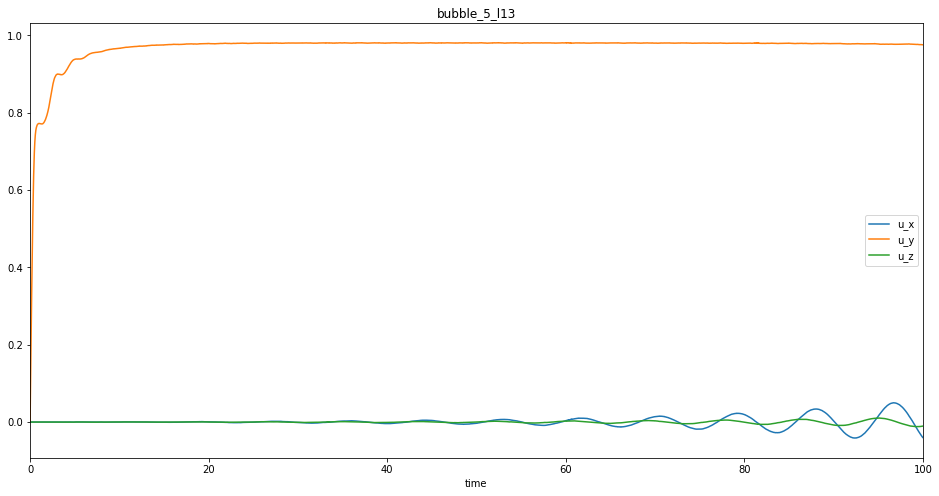

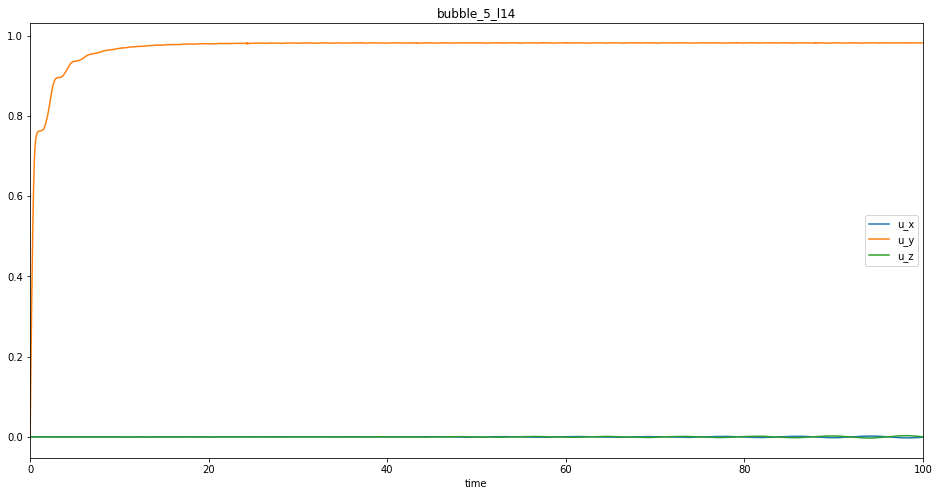

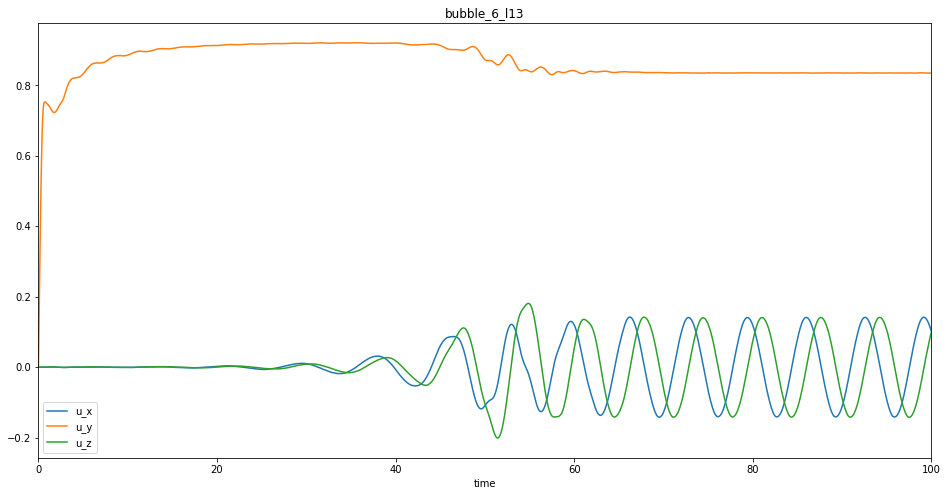

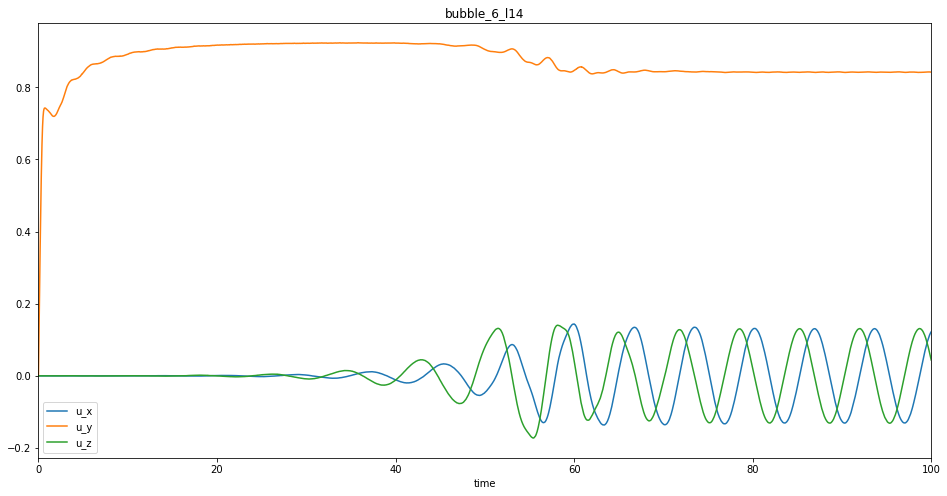

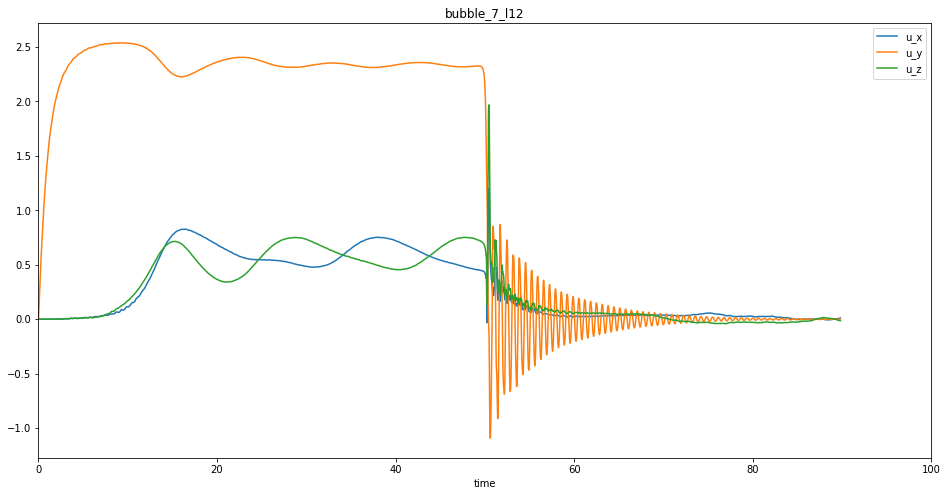

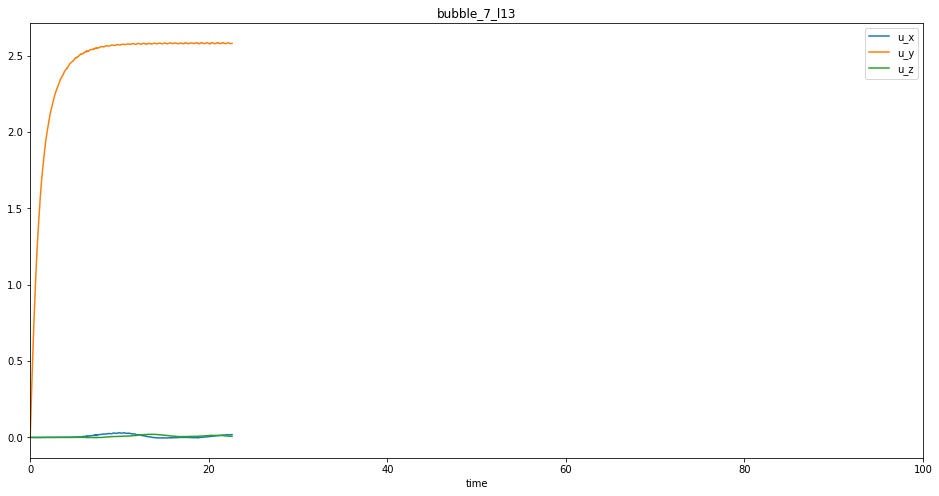

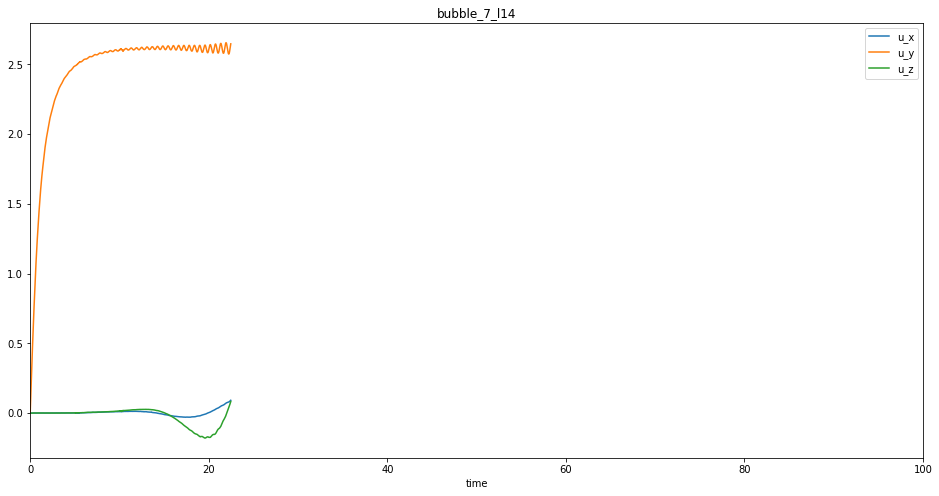

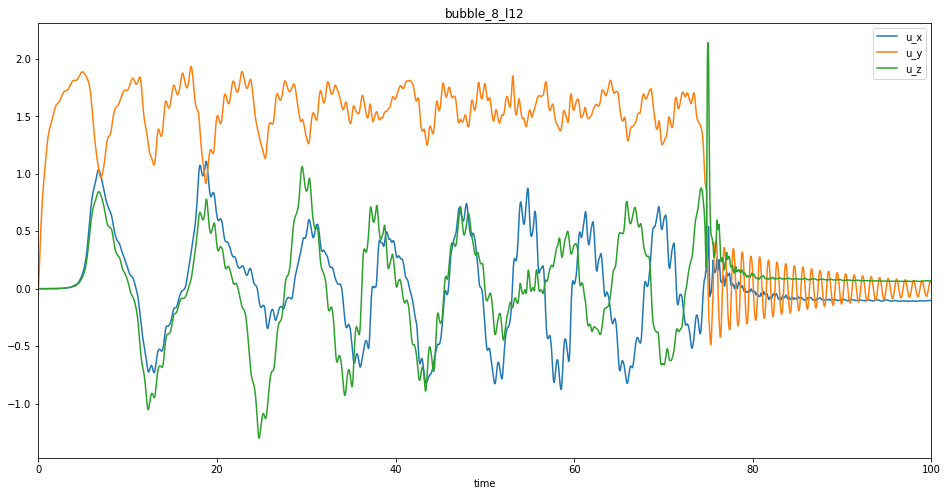

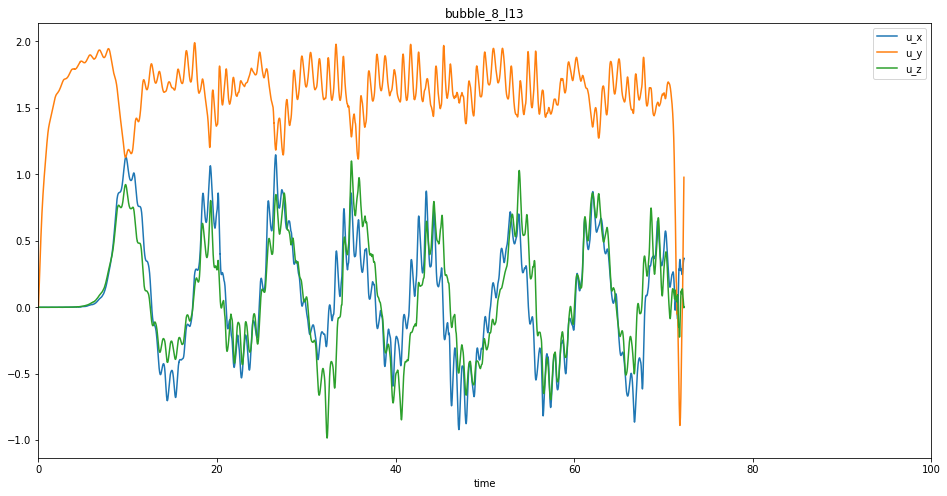

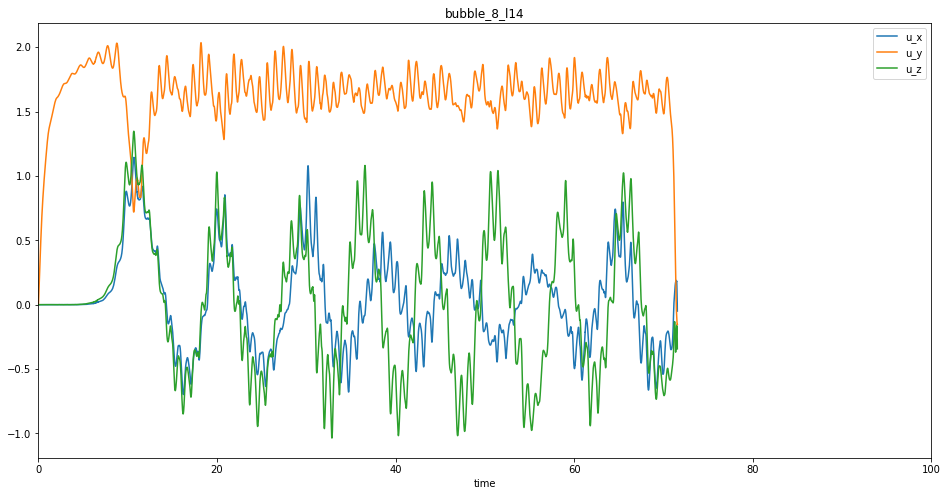

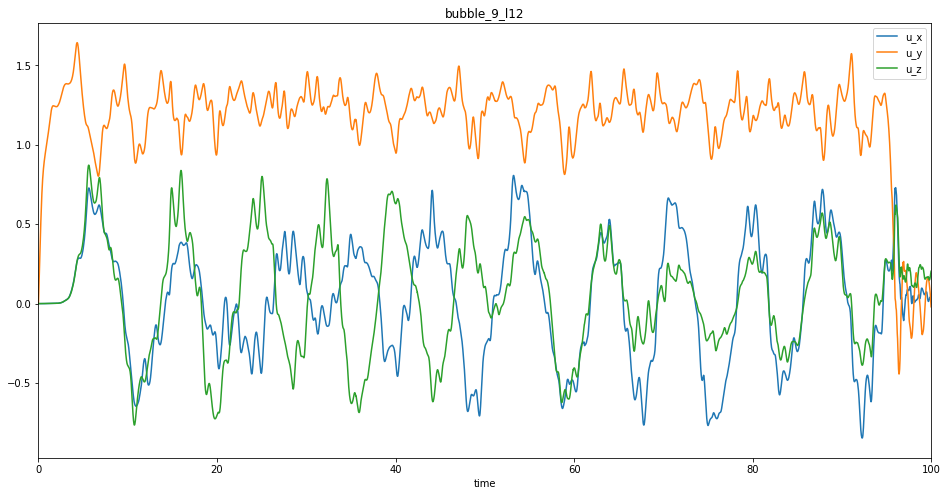

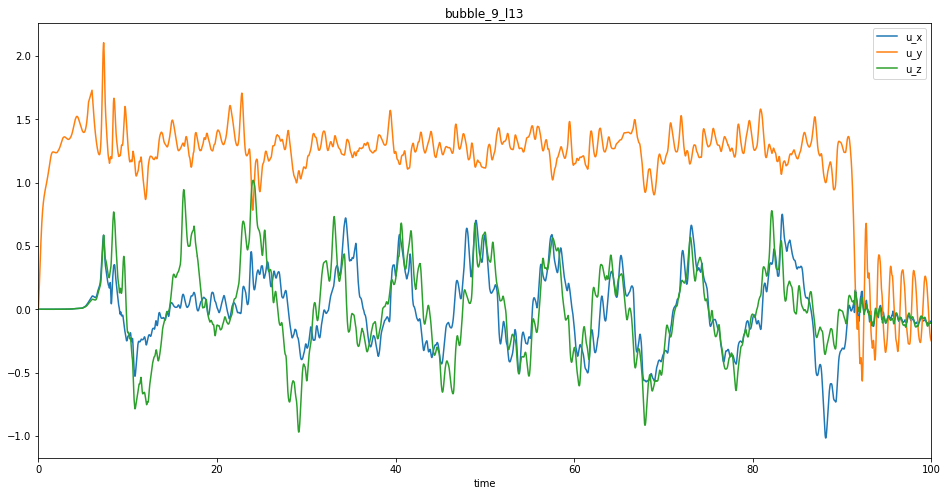

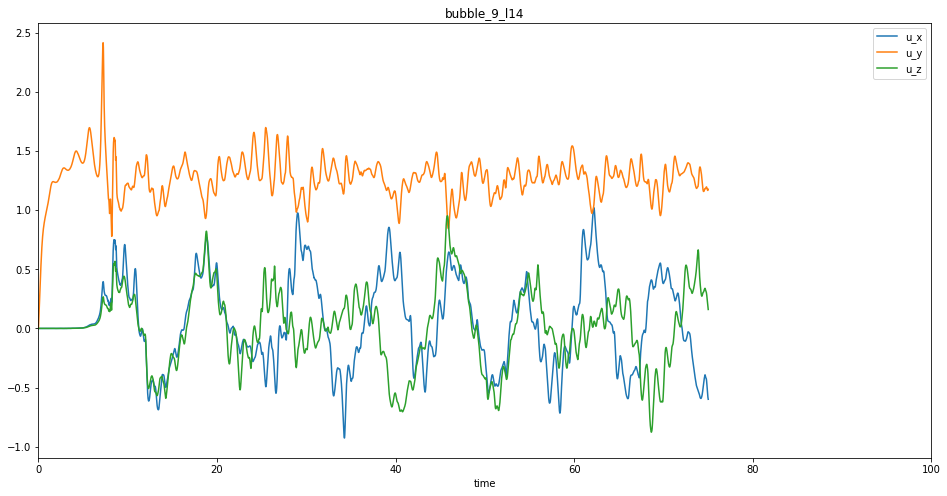

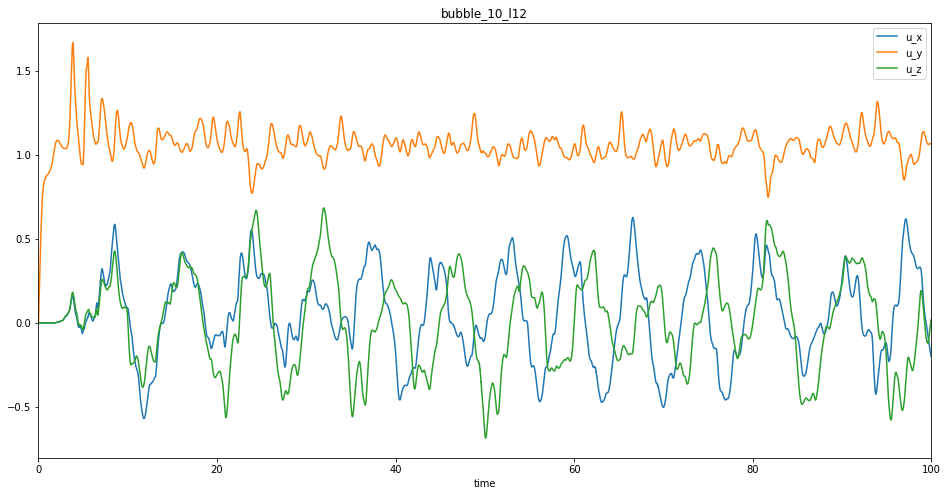

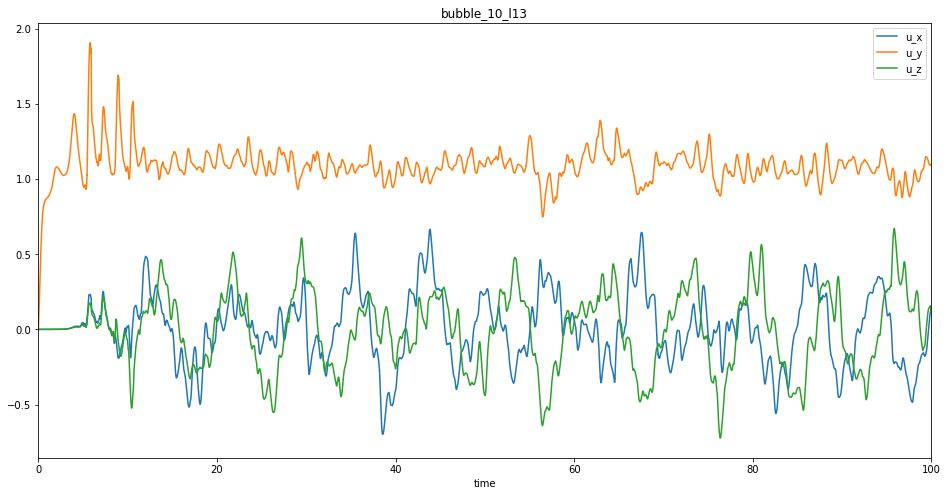

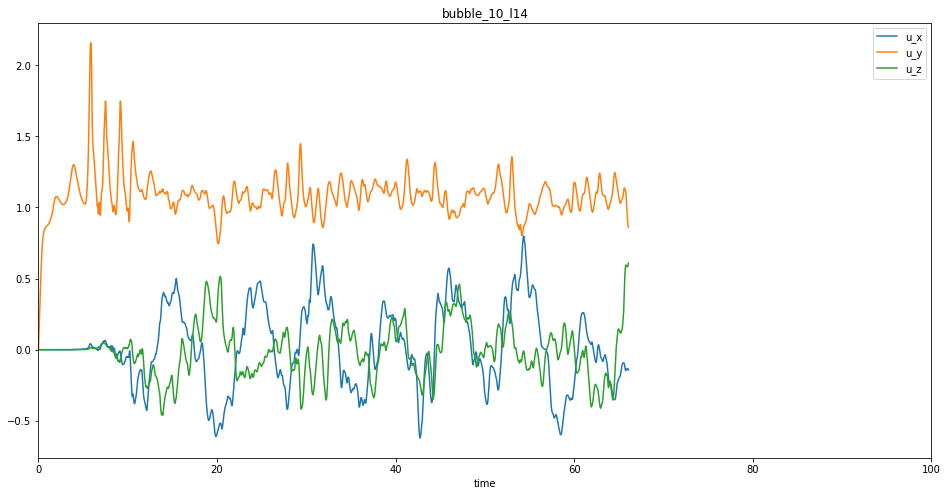

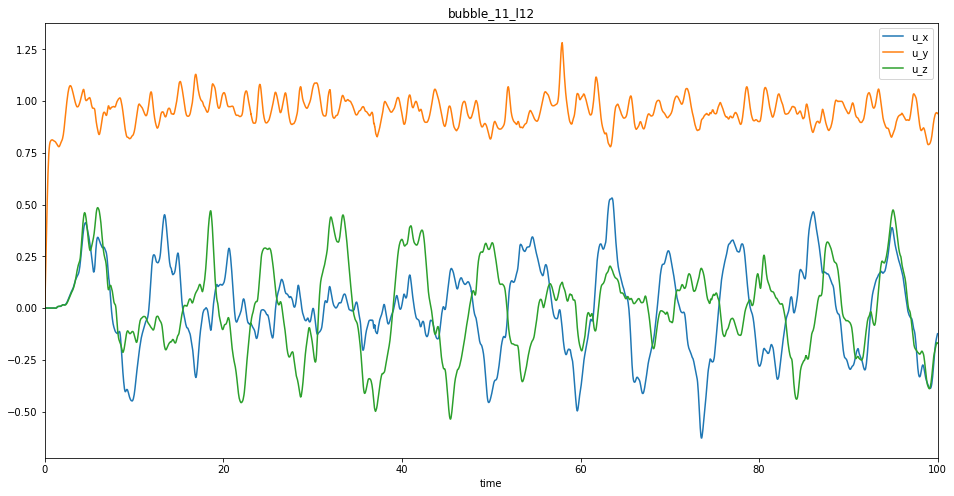

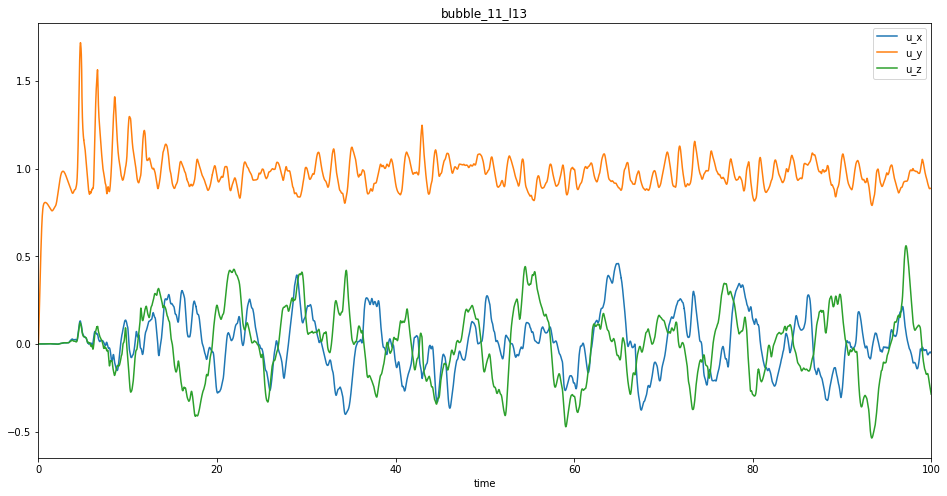

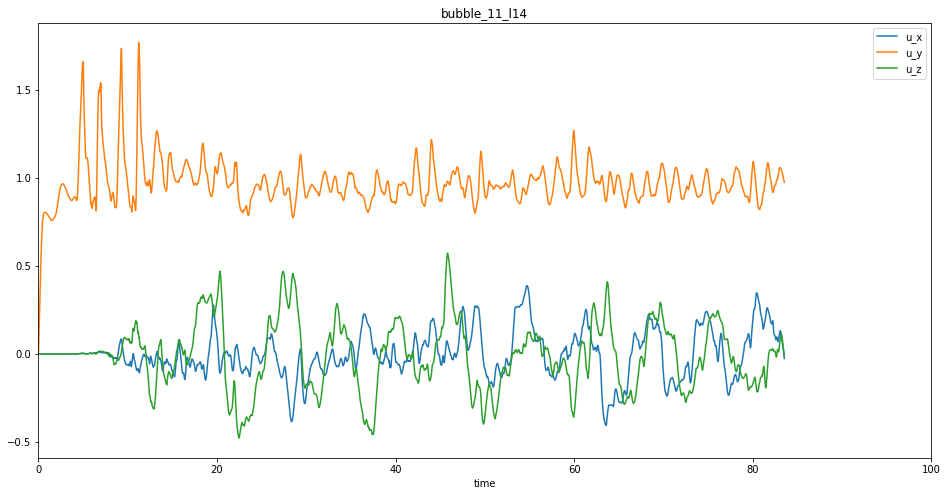

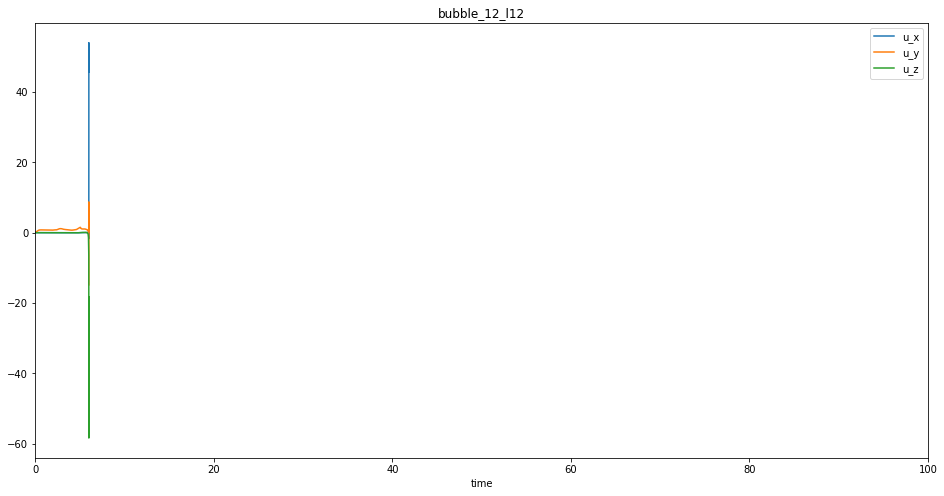

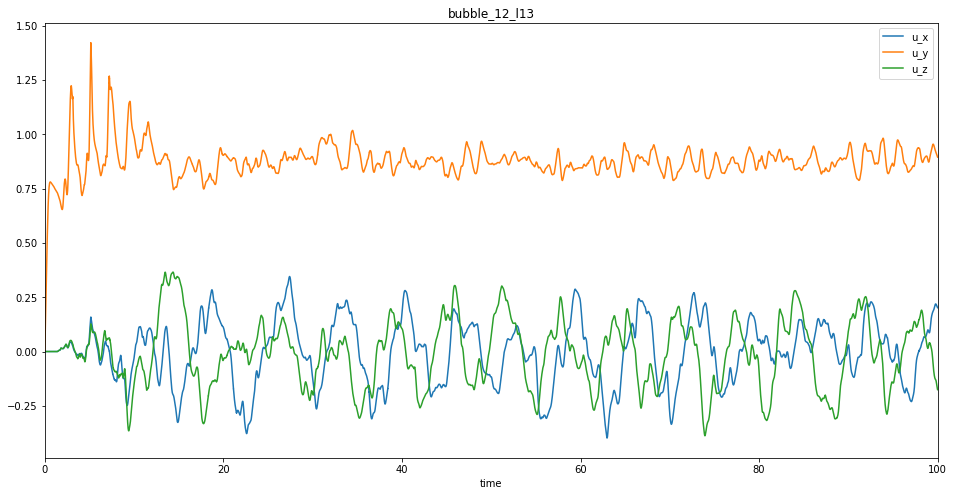

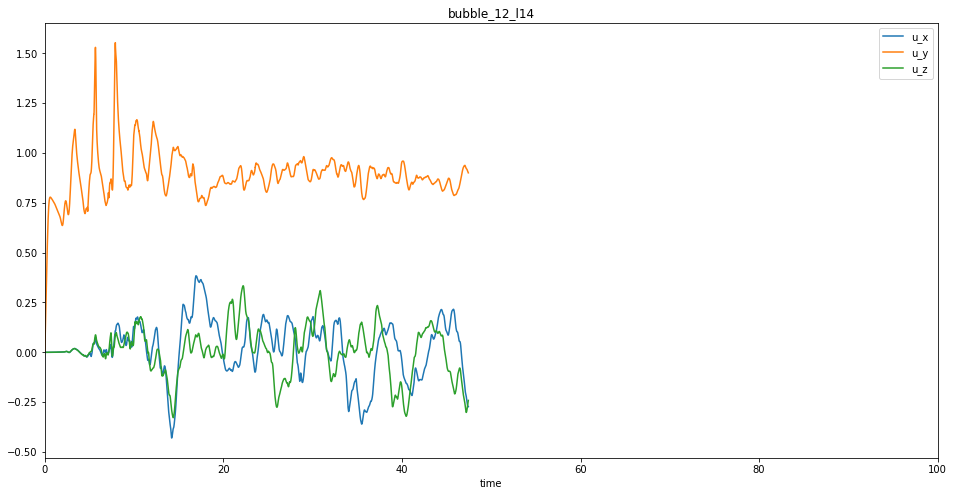

In [7]:
for case in logs.keys():
    logs[case].plot('time', ['u_x','u_y', 'u_z'], title=case, figsize=(16, 8), xlim=(0, 100))

### Surface area and volume

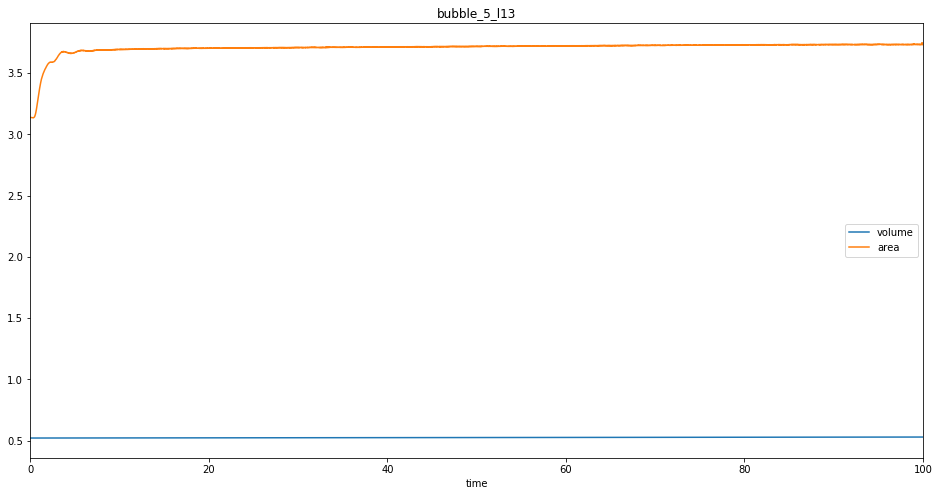

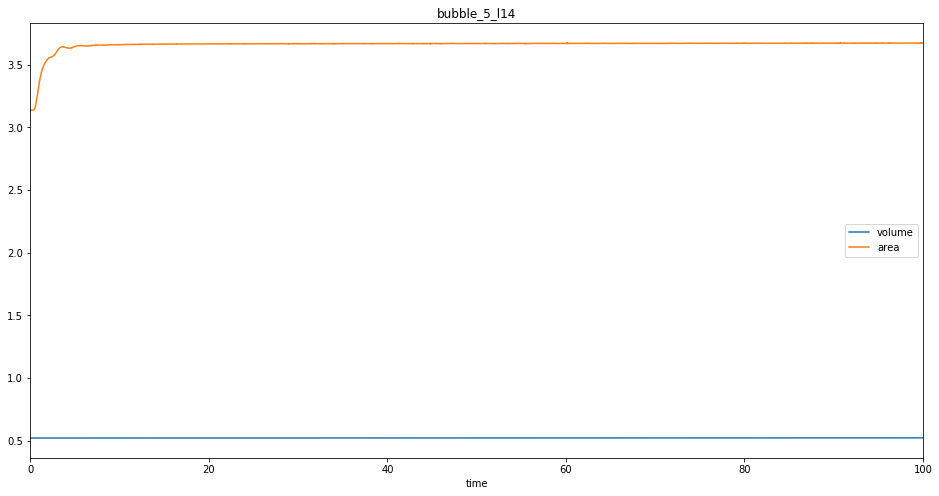

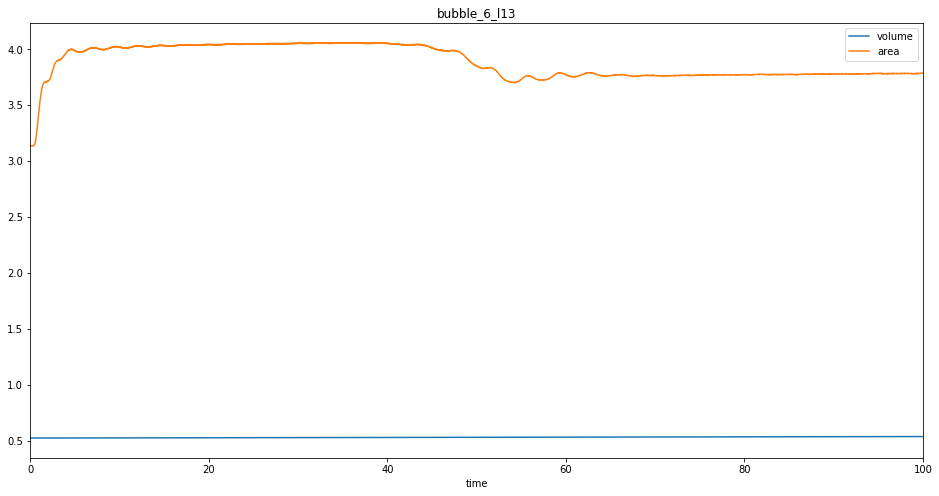

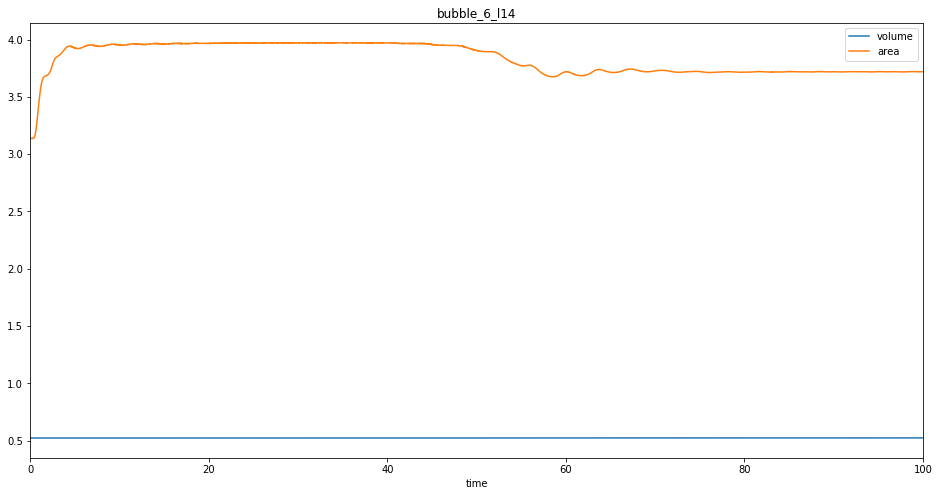

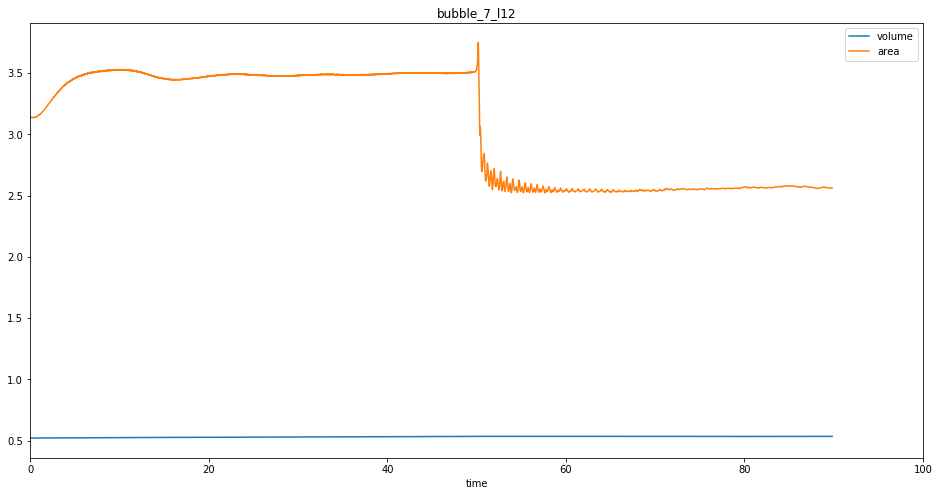

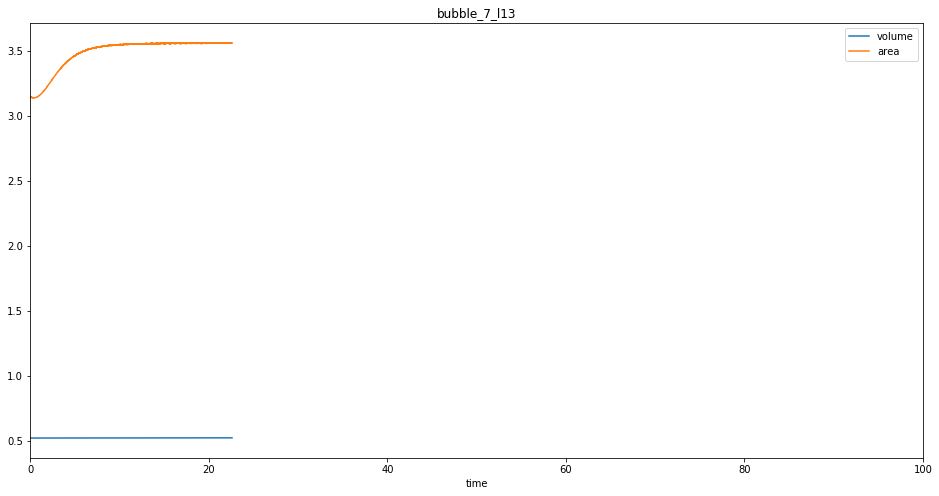

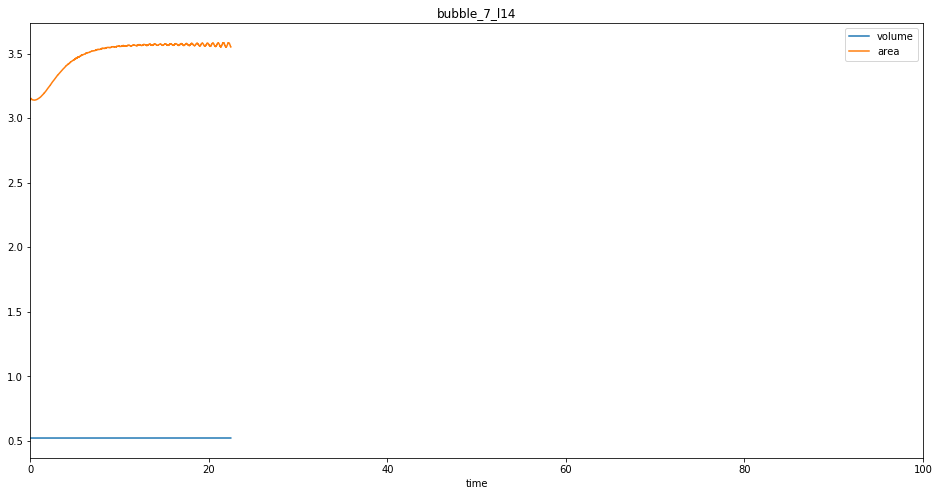

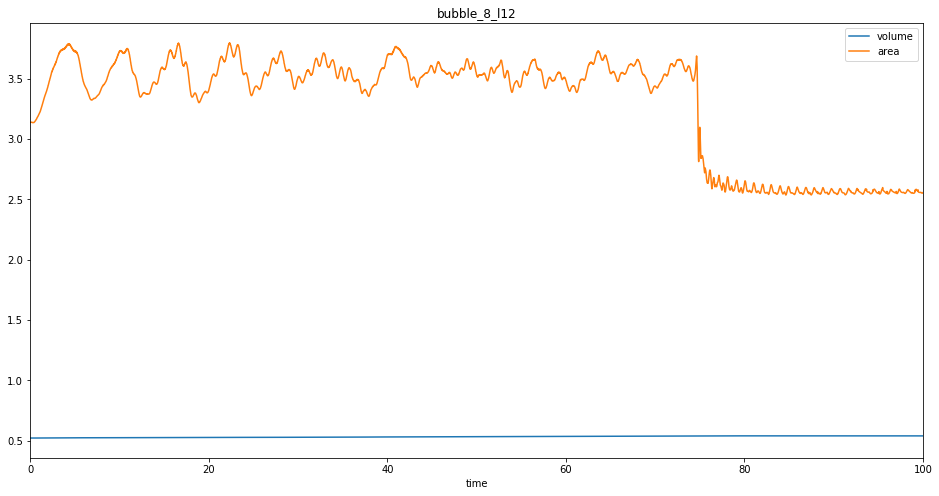

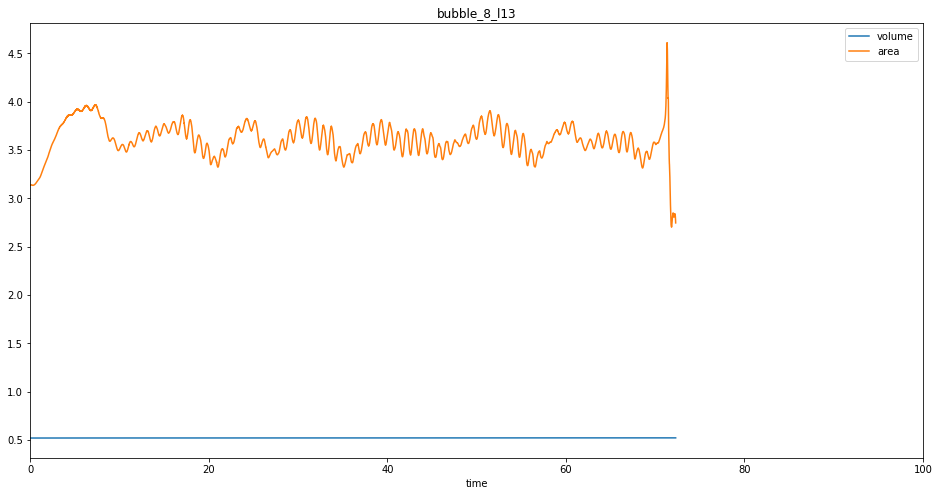

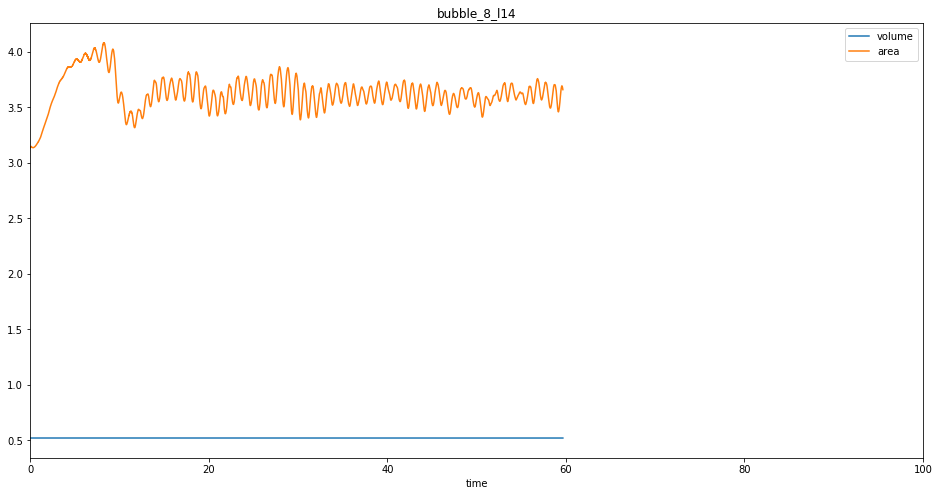

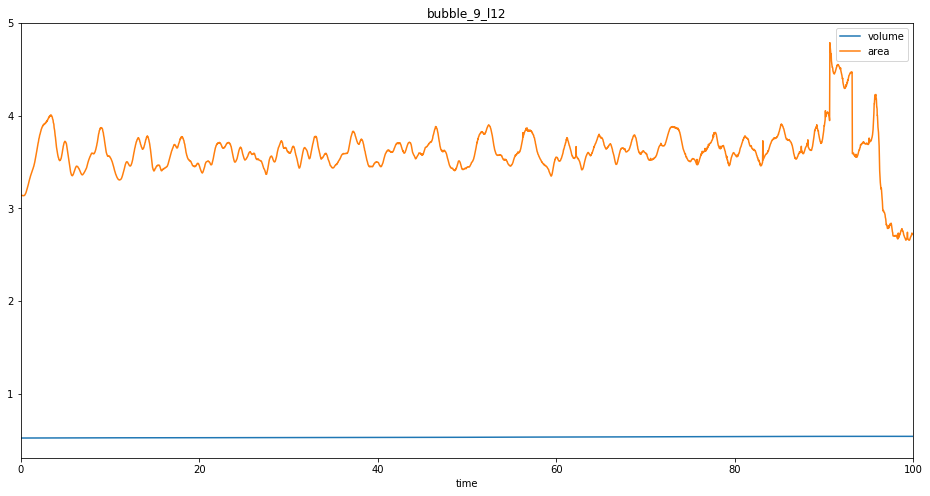

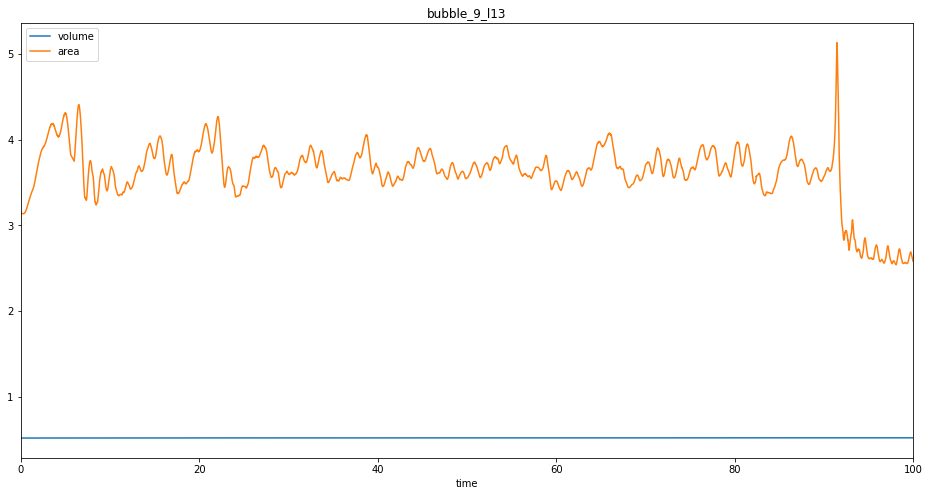

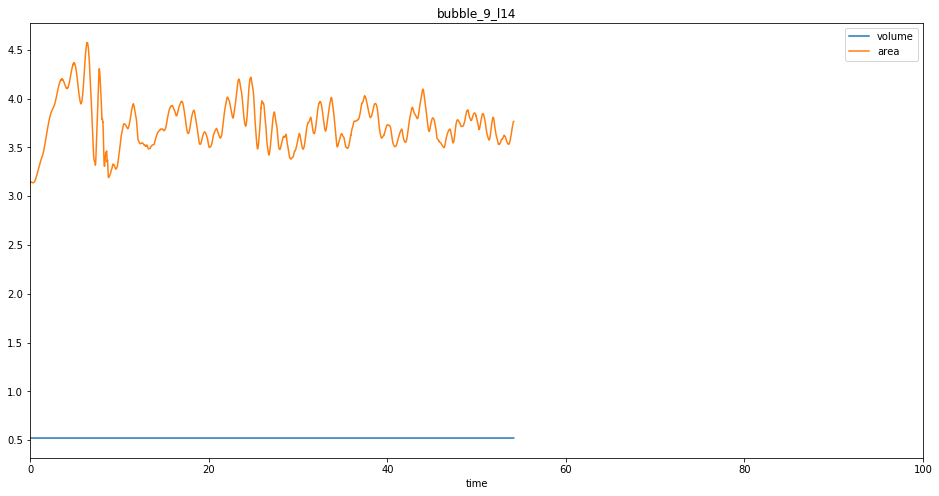

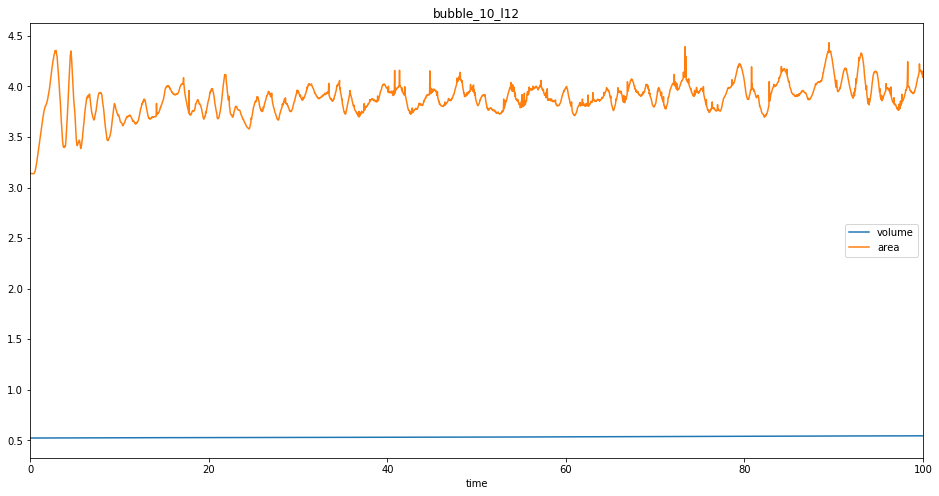

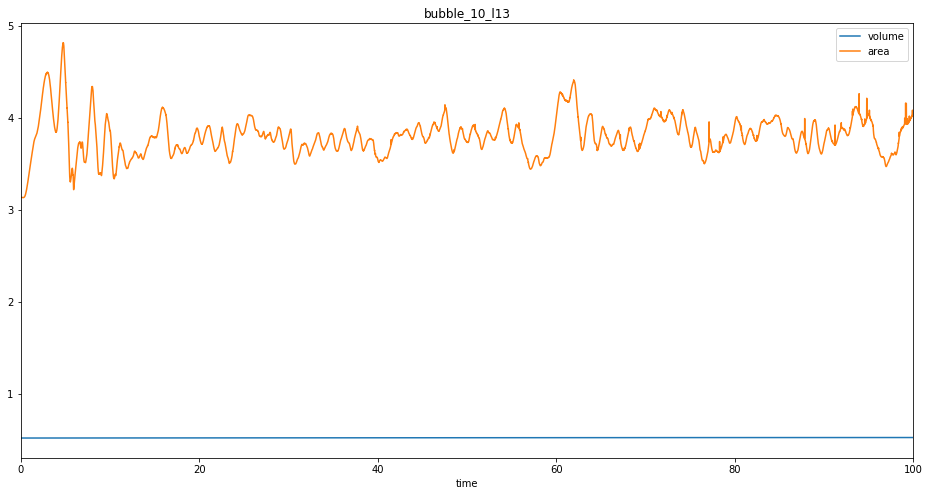

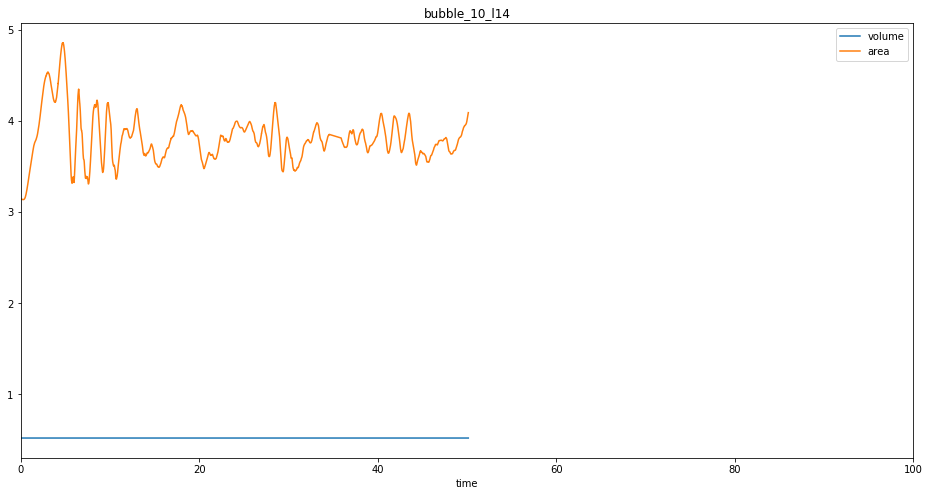

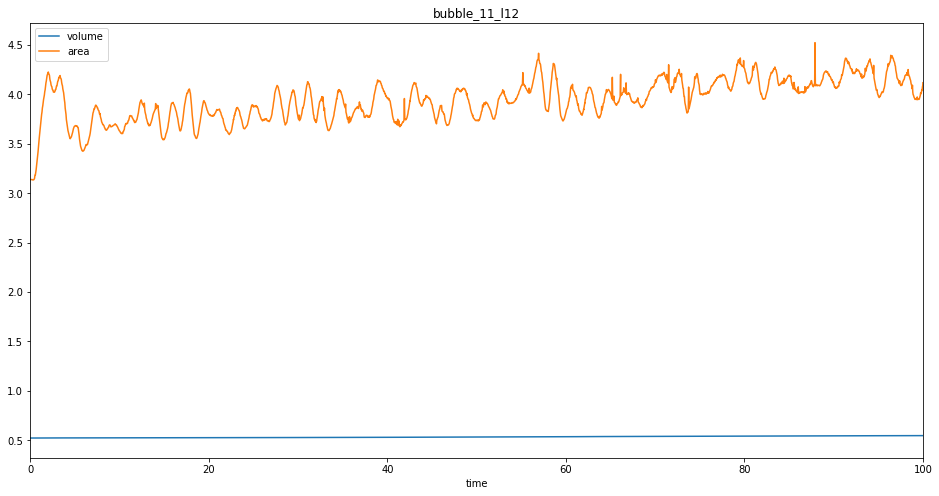

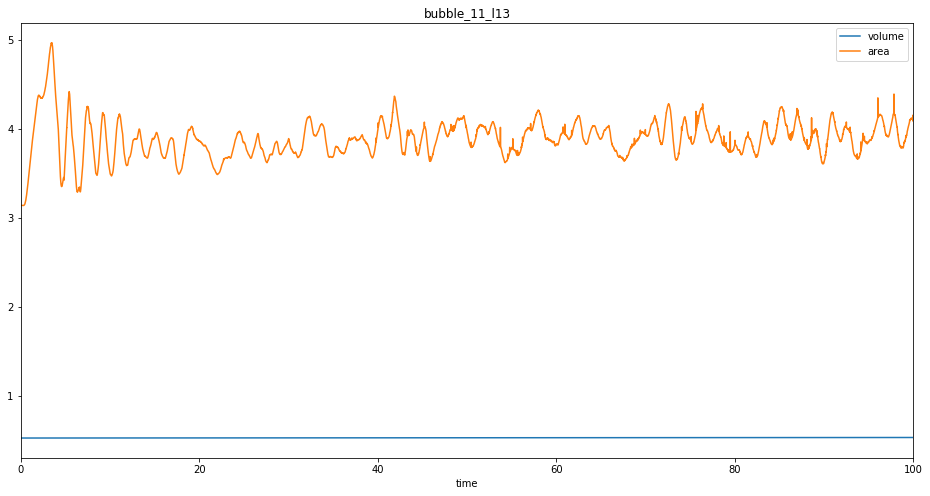

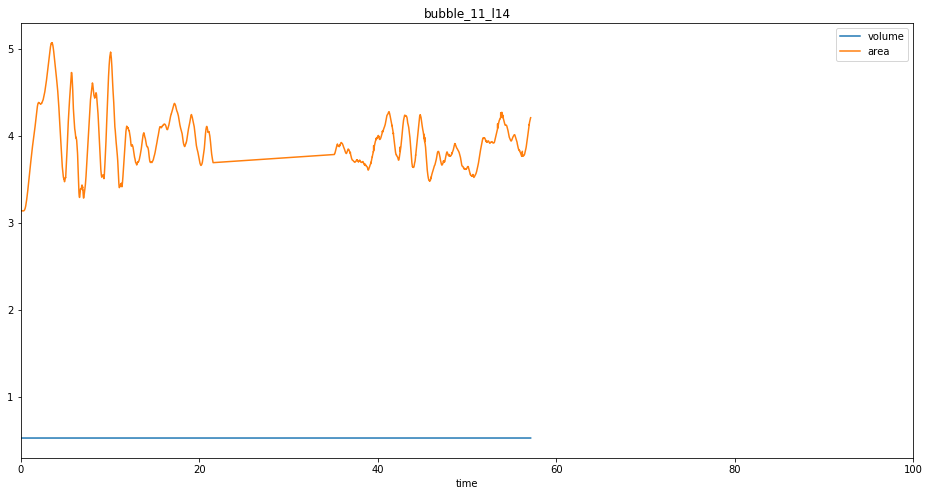

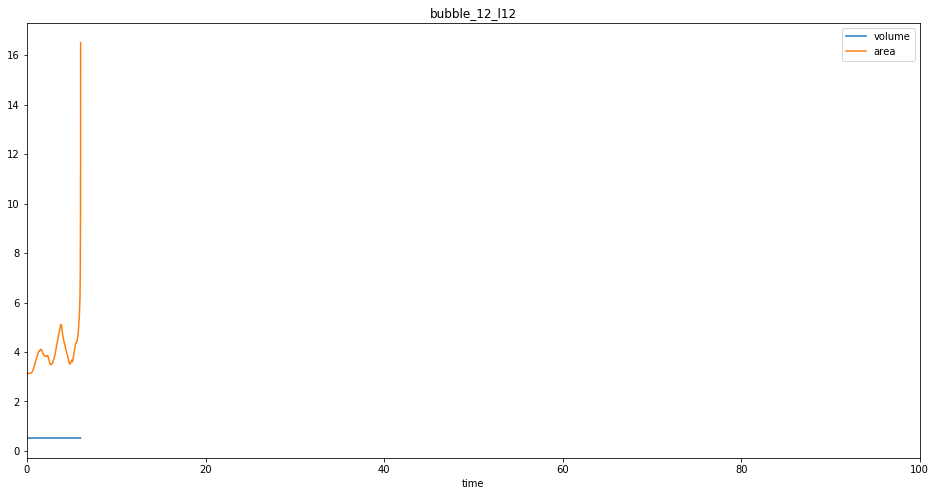

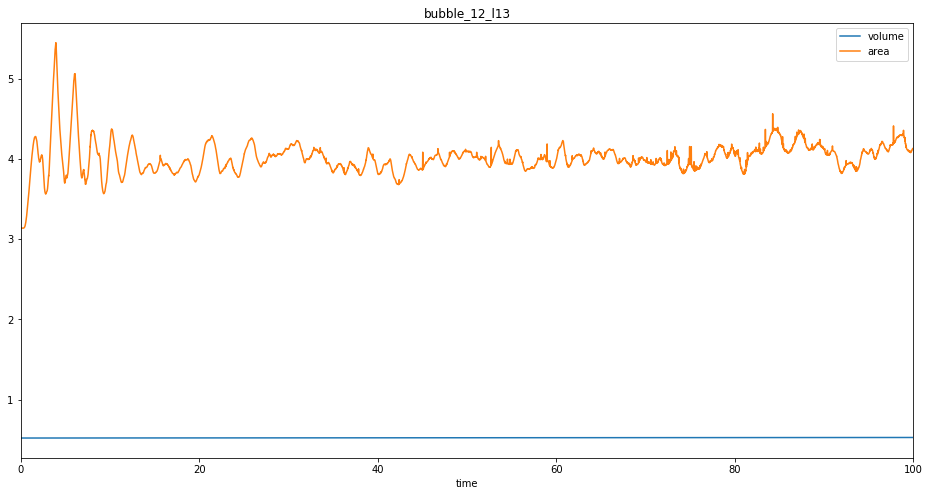

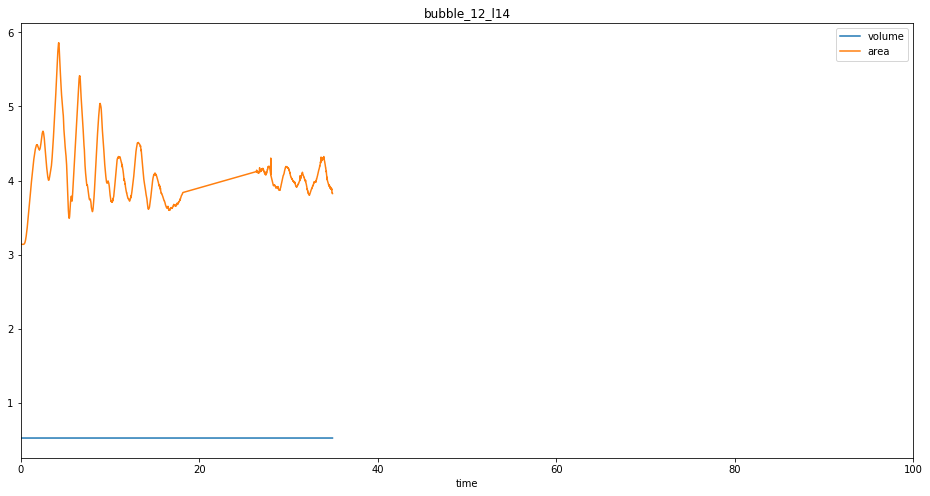

In [8]:
for case in logs.keys():
    logs[case].plot('time', ['volume', 'area'], title=case, figsize=(16, 8), xlim=(0, 100))

### Rigid body angular velocity

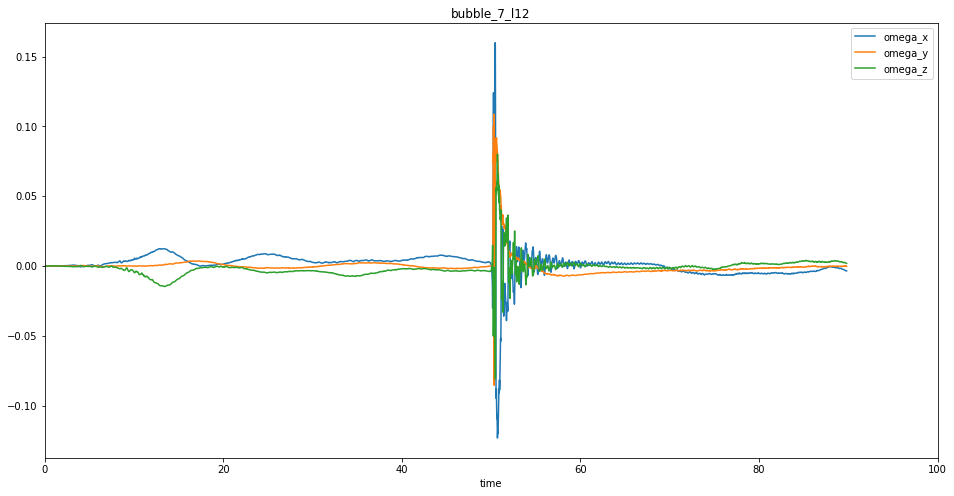

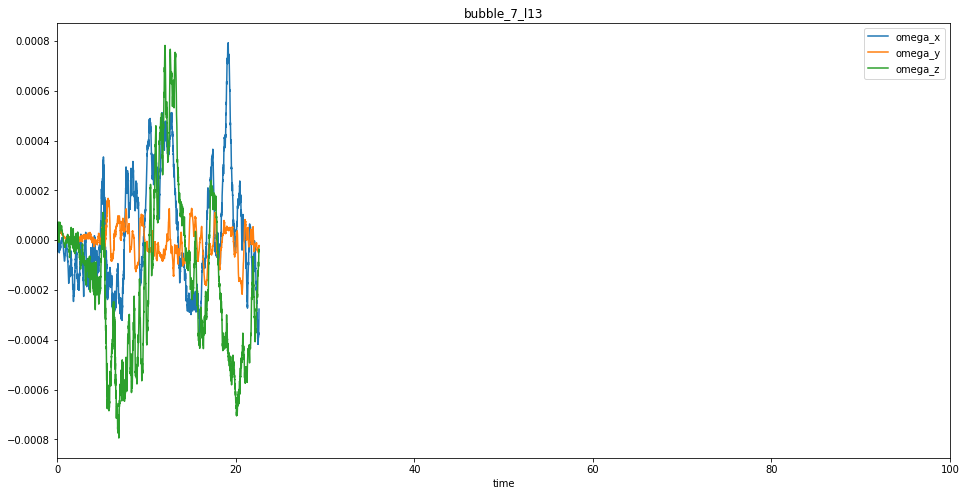

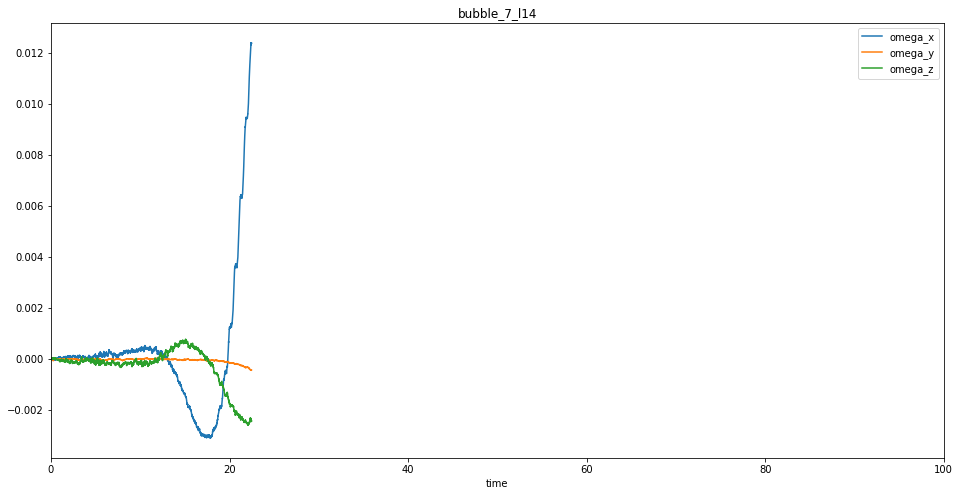

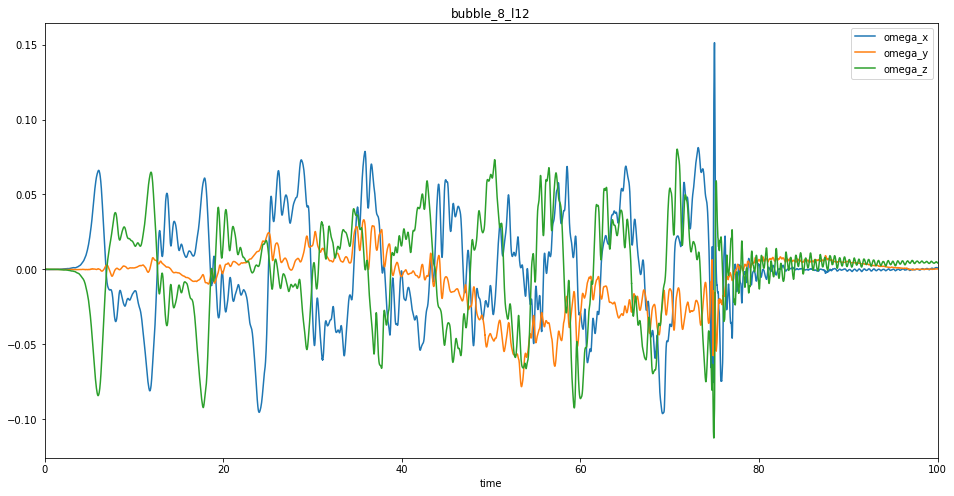

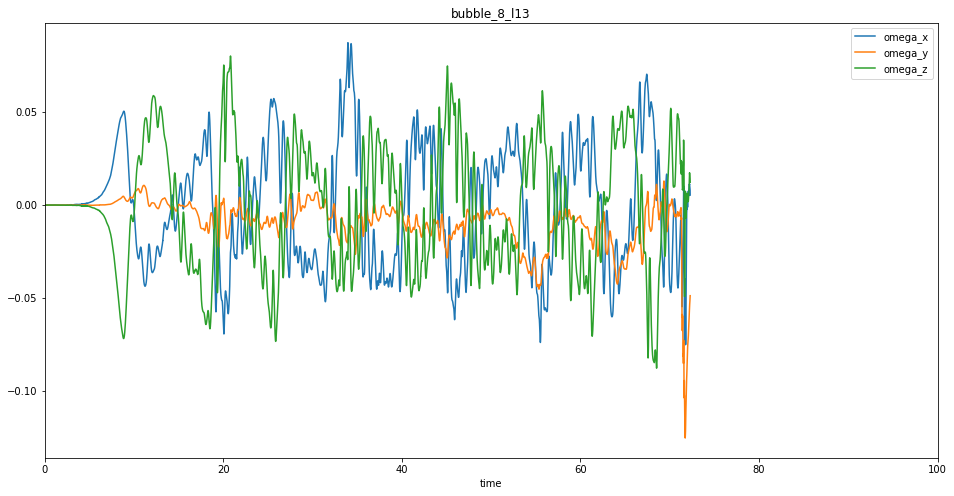

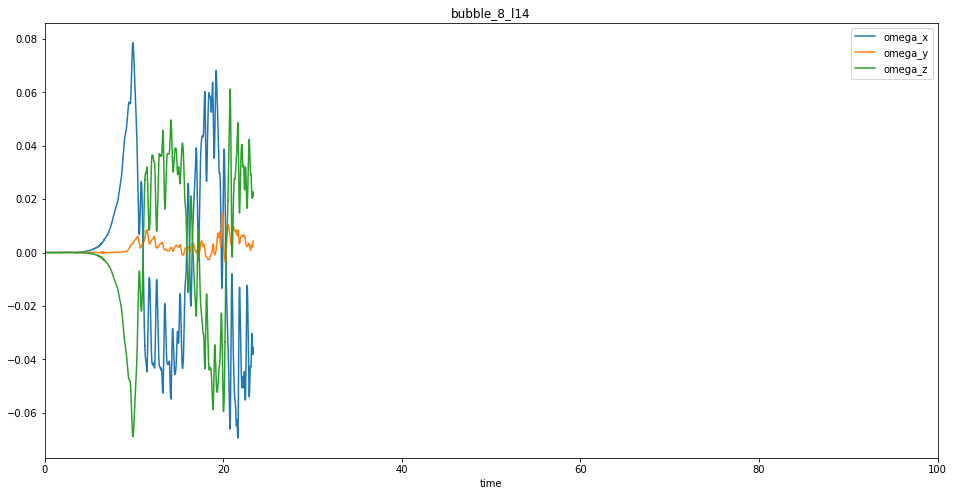

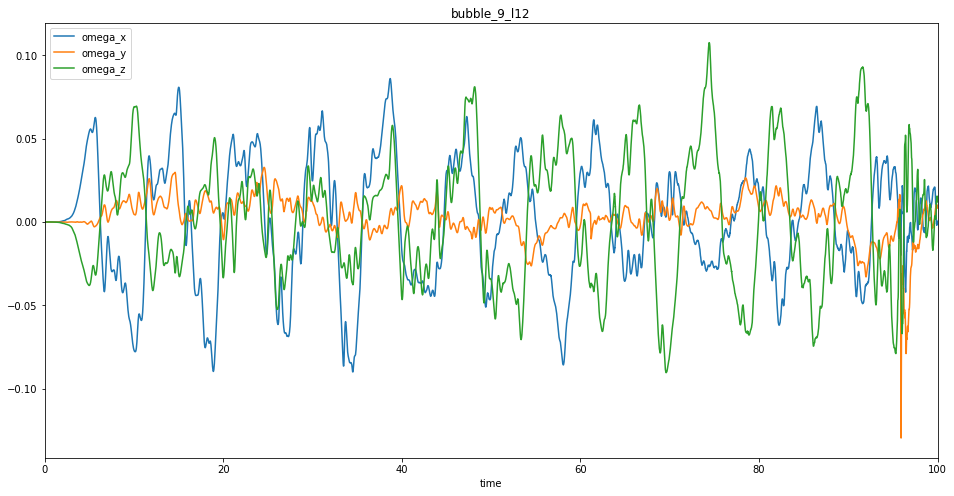

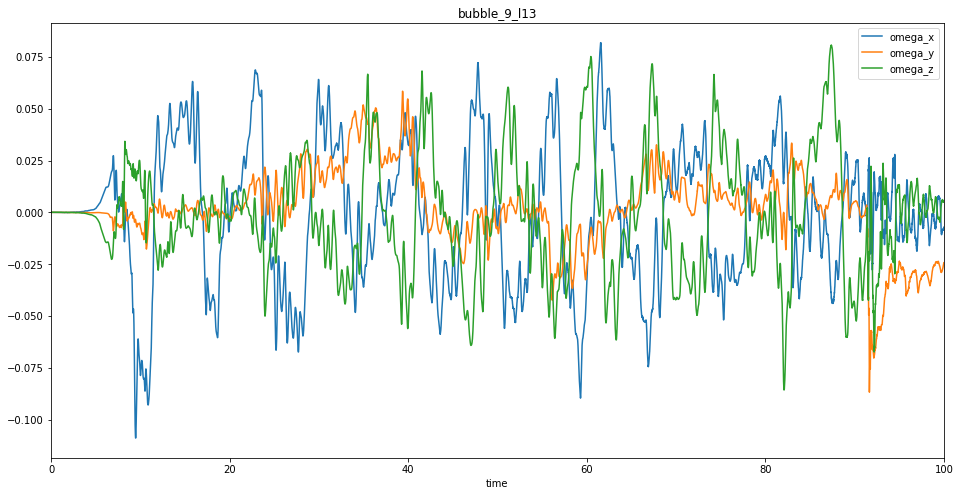

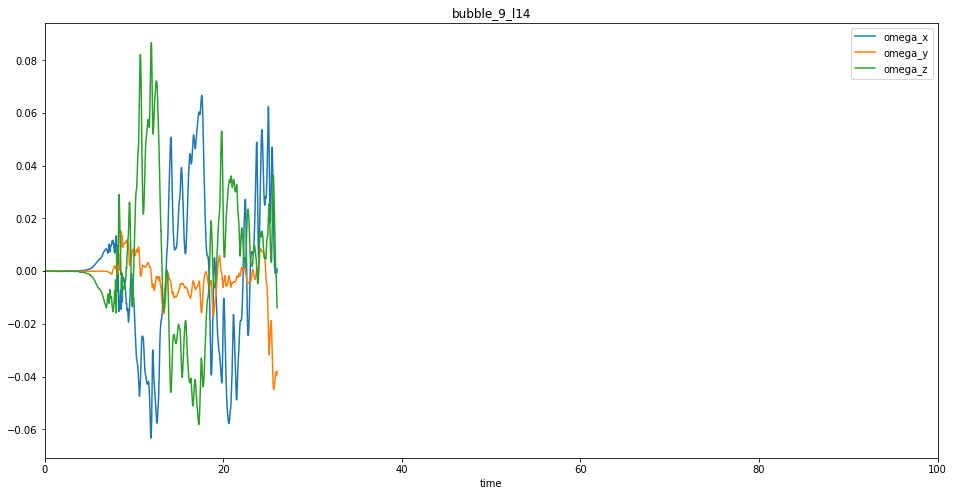

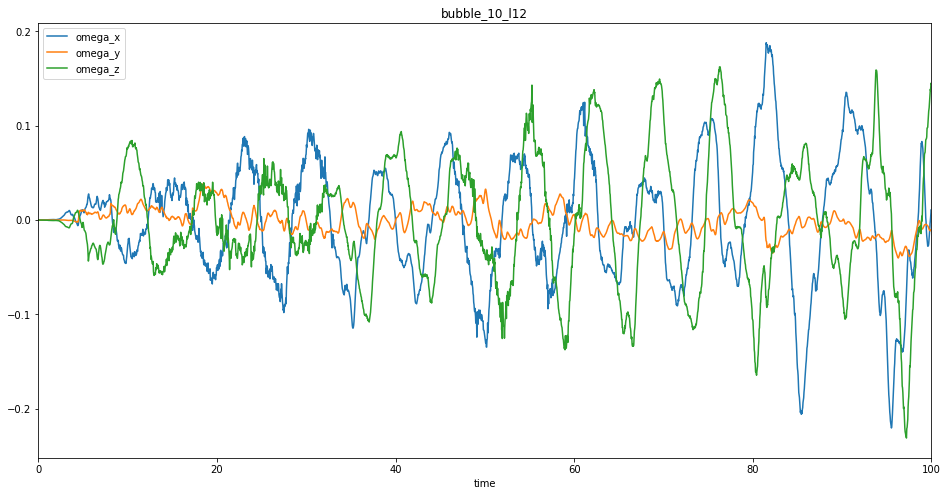

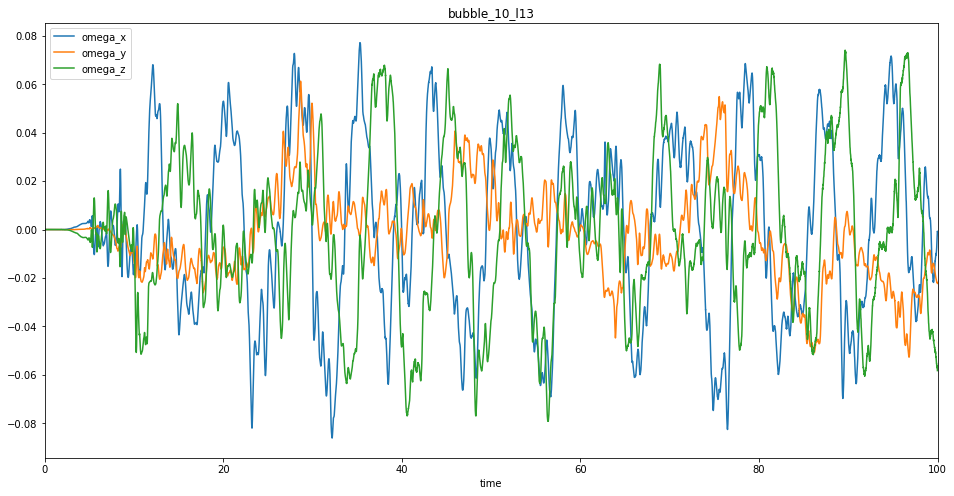

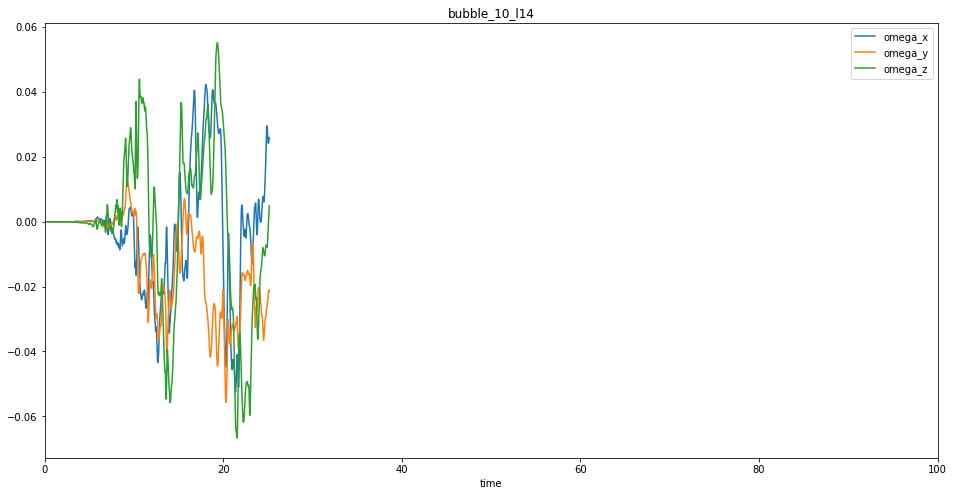

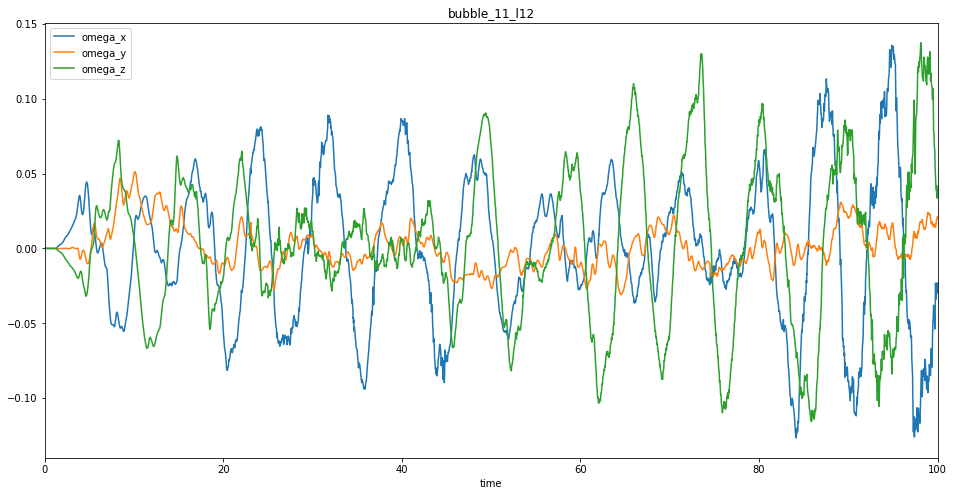

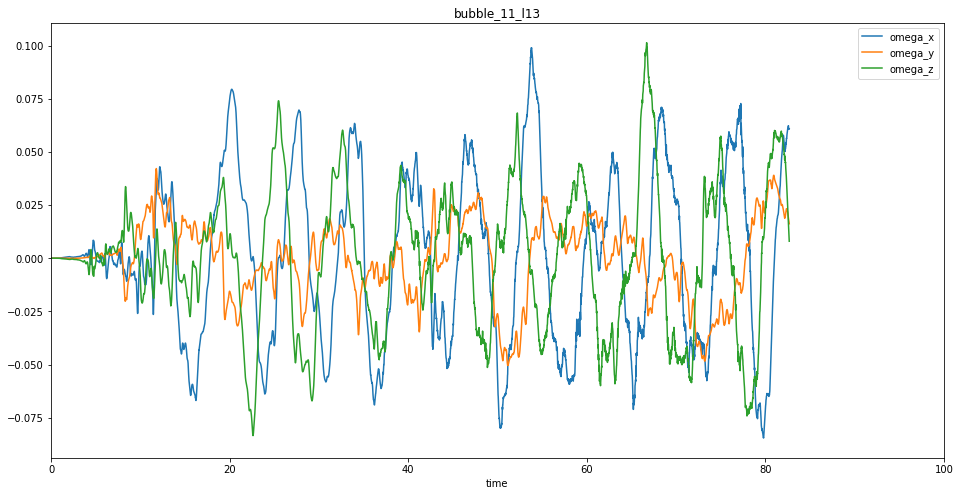

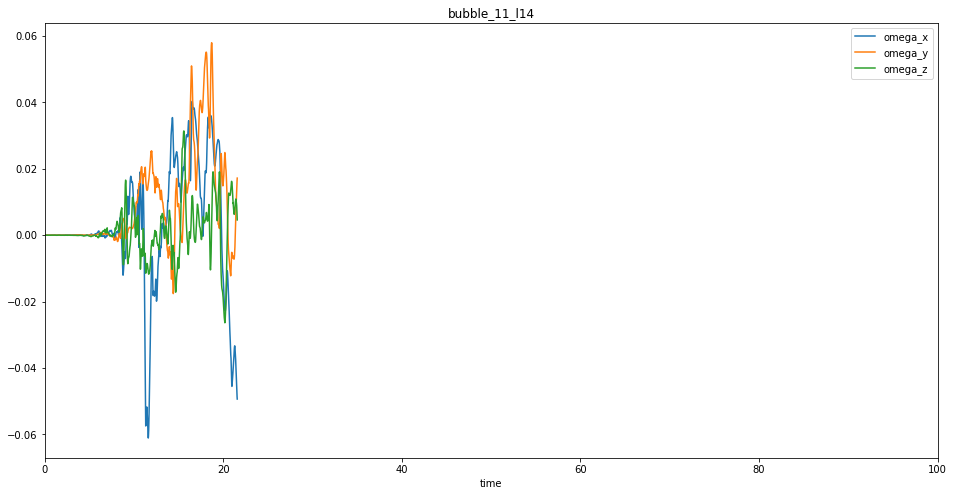

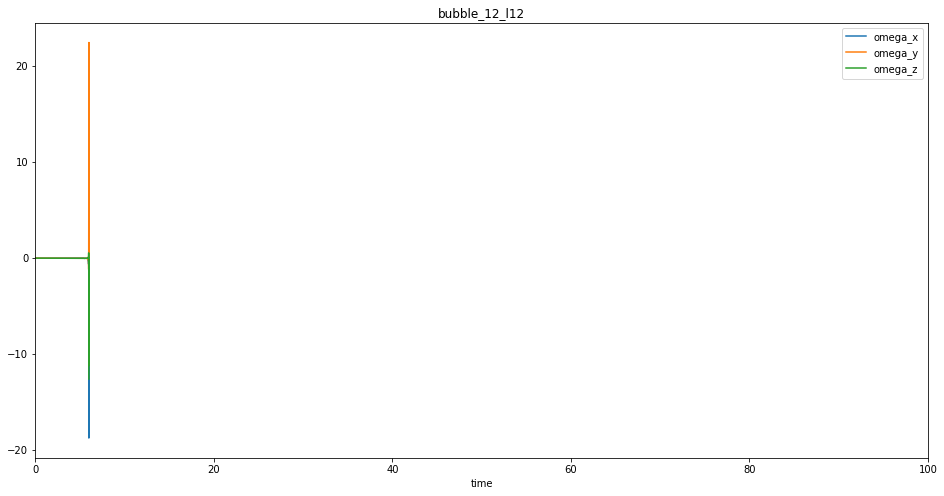

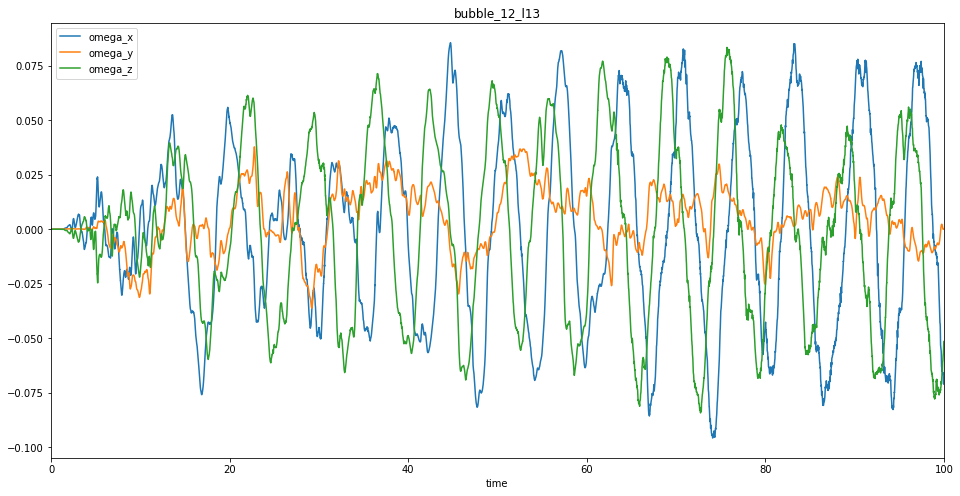

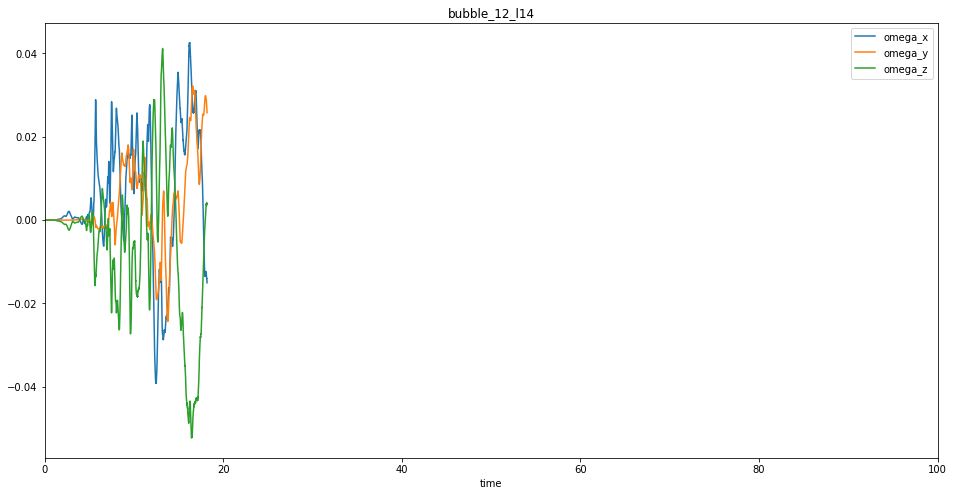

In [8]:
for case in logs.keys():
    logs[case].plot('time', ['omega_x', 'omega_y', 'omega_z'], title=case, figsize=(16, 8), xlim=(0, 100))

### Paths

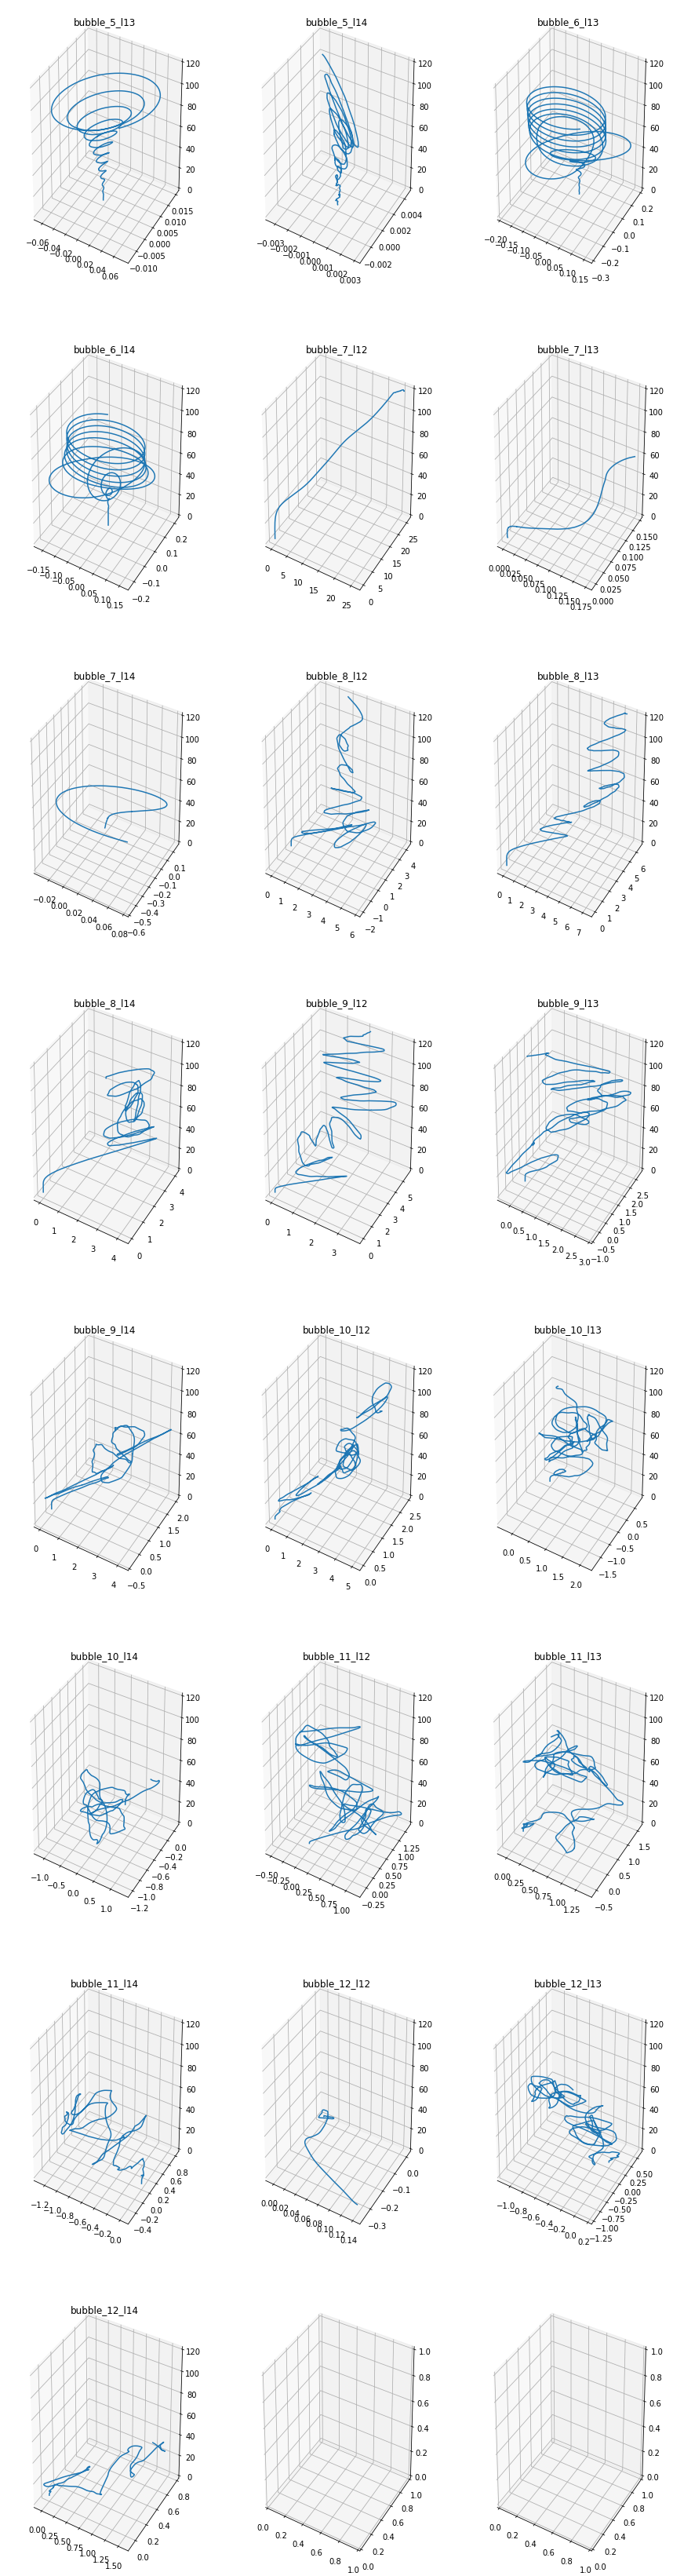

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

rows = int(len(logs.keys()) / 3)
if len(logs.keys()) % 3 > 0: rows += 1
f, axarr = plt.subplots(rows, 3, figsize=(15, 60), subplot_kw={'projection':'3d'})

row, col = 0, 0
for i, case in enumerate(logs.keys()):
    log = logs[case]
    axarr[row, col].plot(log.x, log.z, log.y)
    axarr[row, col].set_zlim([0, 120])
    axarr[row, col].set_title(case)
    col += 1
    if (i + 1) % 3 is 0:
        row += 1
        col = 0